In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# For downloading the image.

import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.

import numpy as np
from PIL import Image, ImageDraw, ImageColor, ImageFont, ImageOps

# For measuring the inference time

import time

In [ ]:
def run_detector(detector, path):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}

  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"])

  display_image(image_with_boxes)

Image downloaded to /tmp/tmp59xj4qt3.jpg.
Found 100 objects.
Inference time: 88.94538497924805


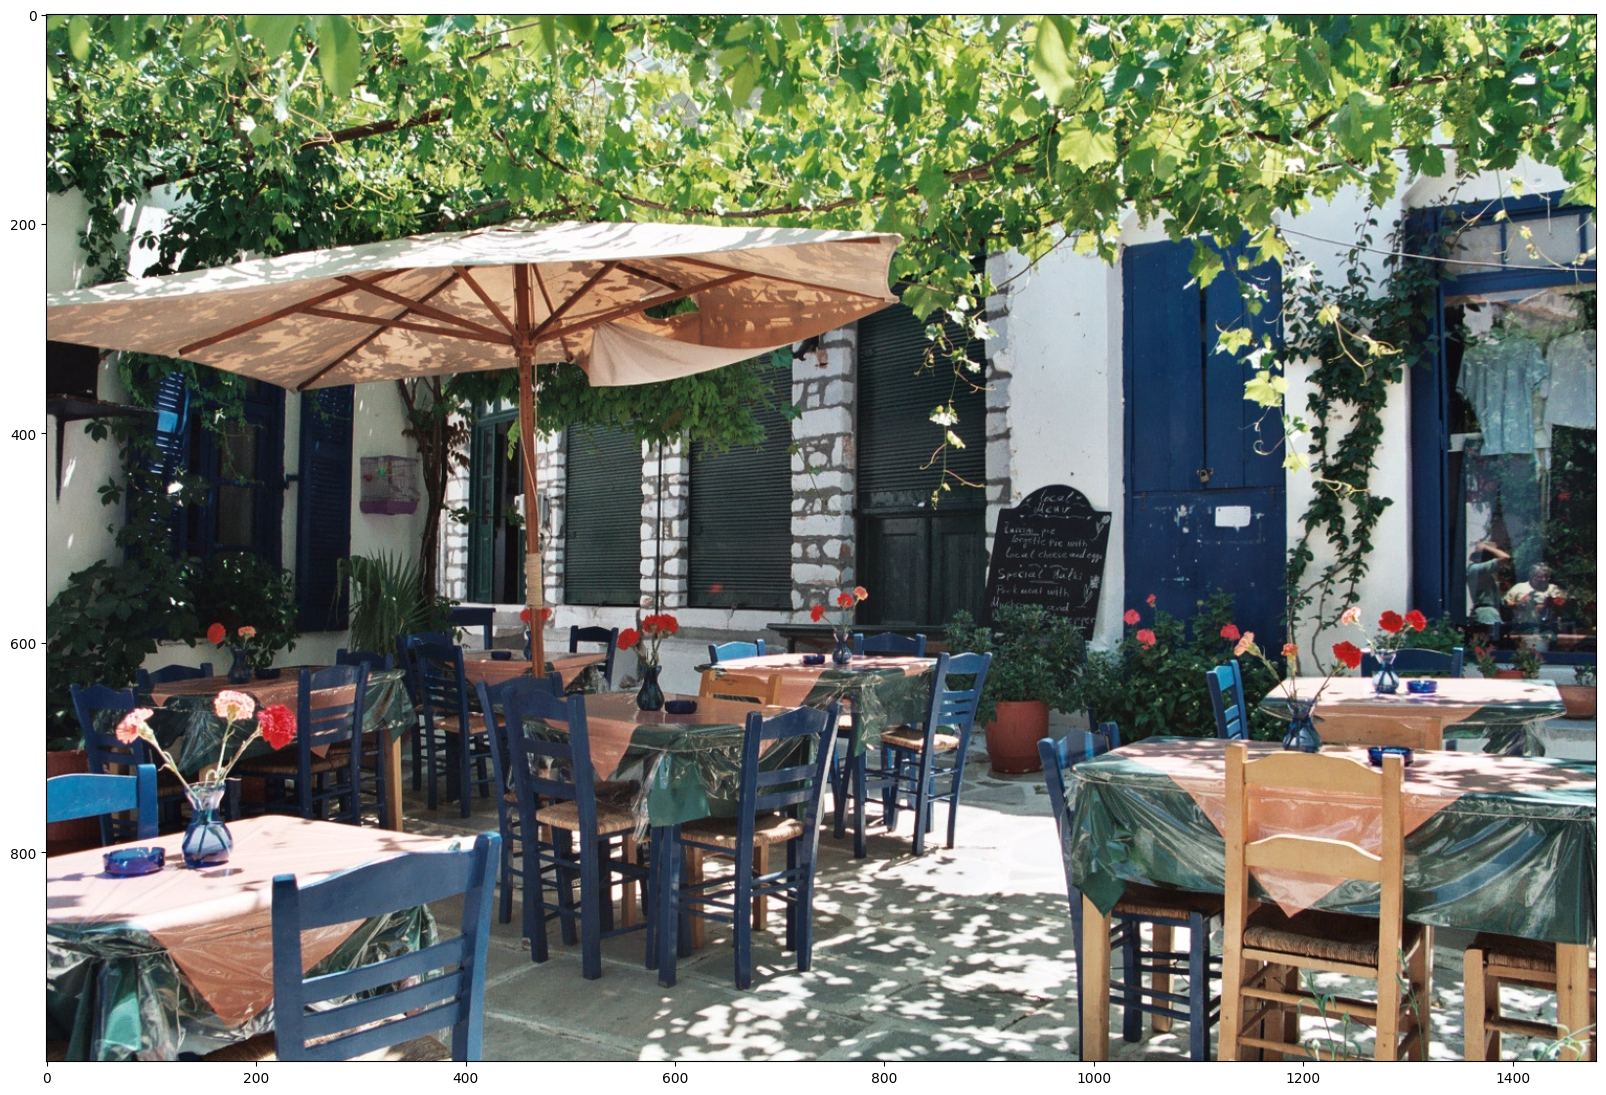

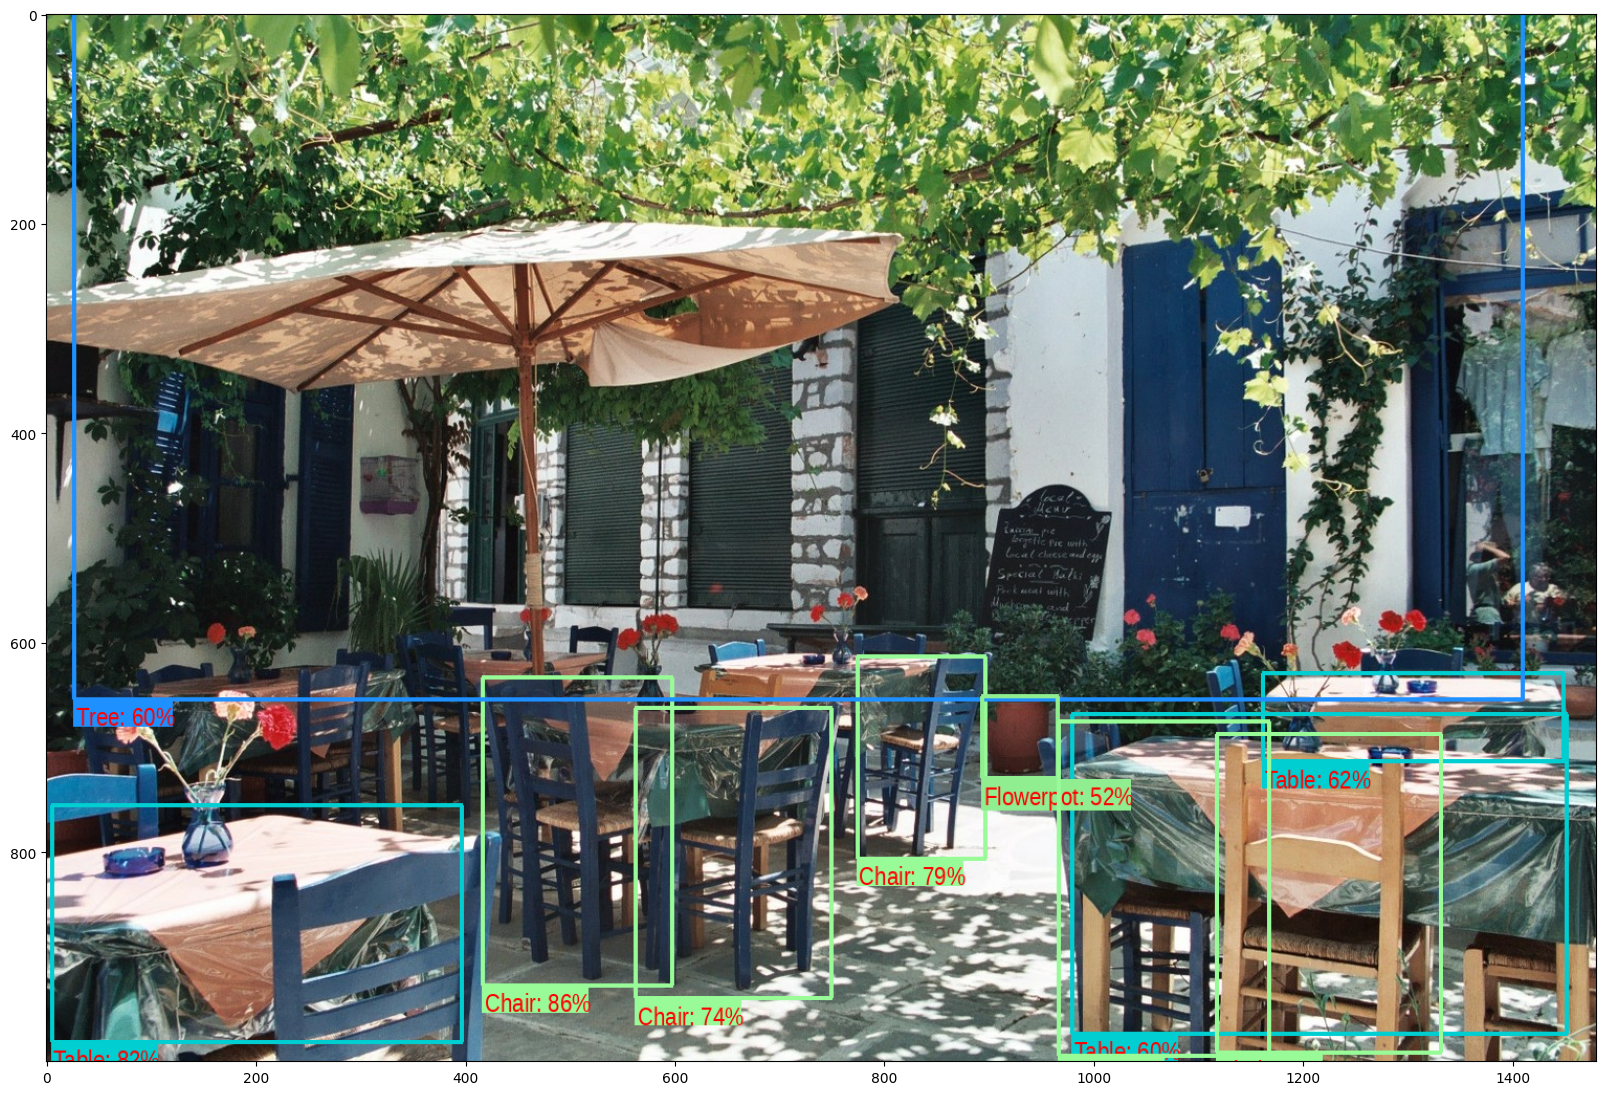

In [ ]:
# Necessary Imports
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
import numpy as np
from PIL import Image, ImageDraw, ImageColor, ImageFont, ImageOps
import time

# Function to Display Images
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

# Function to Download and Resize Image
def download_and_resize_image(url, new_width=256, new_height=256, display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.LANCZOS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    print(f"Image downloaded to {filename}.")
    if display:
        display_image(pil_image)
    return filename

# Function to Draw Bounding Boxes on Images
def draw_boundaries_box_on_image(image, ymin, xmin, ymax, xmax, color, font, thickness=4, display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)

    # Adjust Text Position
    for display_str in display_str_list[::-1]:
        bbox = font.getbbox(display_str)
        text_width, text_height = bbox[2], bbox[3]  # Extract the width and height from the bounding box
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, bottom + margin), (left + text_width, bottom + text_height + margin)], fill=color)
        draw.text((left + margin, bottom + margin), display_str, fill="red", font=font)


# Function to Draw Boxes with Labels and Scores
def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
    """Overlay labeled boxes on an image."""
    colors = list(ImageColor.colormap.values())
    try:
        font = ImageFont.truetype('/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf', 25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(len(boxes), max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = boxes[i]
            display_str = f"{class_names[i].decode('ascii')}: {int(100 * scores[i])}%"
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_boundaries_box_on_image(
                image_pil, ymin, xmin, ymax, xmax, color, font, display_str_list=[display_str]
            )
            np.copyto(image, np.array(image_pil))
    return image

# Load the Image
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

# Run Object Detector
def run_detector(detector, path):
    img = load_img(path)
    converted_img = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    result = {key: value.numpy() for key, value in result.items()}
    print(f"Found {len(result['detection_scores'])} objects.")
    print(f"Inference time: {end_time - start_time}")

    image_with_boxes = draw_boxes(
        img.numpy(), result["detection_boxes"],
        result["detection_class_entities"], result["detection_scores"]
    )
    display_image(image_with_boxes)

# Image URL
image_url = "https://upload.wikimedia.org/wikipedia/commons/6/60/Naxos_Taverna.jpg"
#image_url="https://images.unsplash.com/photo-1554118811-1e0d58224f24?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&w=1000&q=80"
downloaded_image_path = download_and_resize_image(image_url, 1480, 1000, True)

# Load Detector Model
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"
detector = hub.load(module_handle).signatures['default']

# Run Detection
run_detector(detector, downloaded_image_path)
